In [7]:
%cd /Users/masha/Documents/visual-reasoning

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import timm
import kornia.geometry.transform as K
import random
import cv2

/Users/masha/Documents/visual-reasoning


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
BATCH_SIZE = 16
IMG_SIZE = 224
BLOCK_SIZE = 25
LR = 1e-4
EPOCHS = 30

print(f"Running on {DEVICE}")

CHIRAL_SHAPES = {
    'Tetris_L': [(0, -1), (0, 0), (0, 1), (1, 1)],
    'Tetris_J': [(0, -1), (0, 0), (0, 1), (-1, 1)],
    'Tetris_S': [(0, 0), (1, 0), (0, 1), (-1, 1)],
    'Tetris_Z': [(0, 0), (-1, 0), (0, 1), (1, 1)],
    'Pento_F':  [(0, 0), (0, -1), (1, -1), (-1, 0), (0, 1)],
    'Pento_P':  [(0, 0), (0, -1), (1, -1), (1, 0), (0, 1)],
    'Pento_N':  [(0, 0), (0, -1), (1, 0), (1, 1), (1, 2)],
    'Pento_W':  [(-1, -1), (-1, 0), (0, 0), (0, 1), (1, 1)],
}

def draw_chiral_base(shape_name):
    """Draws the base (upright) shape centered on a black canvas."""
    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    center = IMG_SIZE // 2
    offsets = CHIRAL_SHAPES[shape_name]
    
    for dx, dy in offsets:
        x = center + (dx * BLOCK_SIZE) - (BLOCK_SIZE // 2)
        y = center + (dy * BLOCK_SIZE) - (BLOCK_SIZE // 2)
        cv2.rectangle(img, (x, y), (x + BLOCK_SIZE, y + BLOCK_SIZE), 255, -1)
    
    # Normalize to [-1, 1] then ImageNet stats (approx) for DINO
    # Note: We will handle strict normalization in the tensor conversion
    return img

class TetrisBaseDataset(Dataset):
    """Generates a cache of Upright shapes to be rotated on GPU."""
    def __init__(self, n_samples=2000):
        self.data = []
        keys = list(CHIRAL_SHAPES.keys())
        
        print(f"Generating {n_samples} base shapes in memory...")
        for _ in range(n_samples):
            name = random.choice(keys)
            img = draw_chiral_base(name)
            
            # Convert to Tensor (1, H, W) in range [0, 1]
            t = torch.tensor(img).float().unsqueeze(0) / 255.0
            
            # DINOv3 Normalization
            # (ImageNet Mean/Std)
            t = transforms.Normalize(mean=[0.485], std=[0.229])(t)
            self.data.append(t)
            
    def __len__(self): return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Create Data Loader
train_ds = TetrisBaseDataset(n_samples=2000)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

Running on mps
Generating 2000 base shapes in memory...
Data ready.


In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class FlowReasoningModel(nn.Module):
    def __init__(self, backbone, backbone_dim=384, flow_dim=64):
        super().__init__()
        
        self.backbone = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        self.time_mlp = nn.Sequential(
            nn.Linear(1, flow_dim * 4),
            nn.GELU(),
            nn.Linear(flow_dim * 4, flow_dim * 4)
        )

        self.inc = DoubleConv(3, flow_dim)            # -> 64
        self.down1 = Down(flow_dim, flow_dim * 2)     # -> 128
        self.down2 = Down(flow_dim * 2, flow_dim * 4) # -> 256
        
        self.cond_proj = nn.Linear(backbone_dim, flow_dim * 4)

        self.up1 = Up(flow_dim * 6, flow_dim * 2) # (256+128)->128
        self.up2 = Up(flow_dim * 3, flow_dim)     # (128+64)->64
        self.outc = nn.Conv2d(flow_dim, 3, kernel_size=1)

    def forward(self, x_t, t, x0_clean):
        with torch.no_grad():
            feats = self.backbone.forward_features(x0_clean)
            cls_token = feats[:, 0, :] 

        t_emb = self.time_mlp(t)             
        cond = self.cond_proj(cls_token)     
        global_cond = (t_emb + cond).unsqueeze(-1).unsqueeze(-1) # Broadcast to Spatial

        x1 = self.inc(x_t)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        
        # Geom + conditional aka visual + instruction for each pixel
        x3 = x3 + global_cond
        
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        return self.outc(x)

dinov3 = timm.create_model("vit_small_patch16_dinov3", pretrained=True, num_classes=0)
dinov3.to(DEVICE)
dinov3.eval()

model = FlowReasoningModel(backbone=dinov3)
model = model.to(DEVICE)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

In [ ]:
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for batch_idx, x_base in enumerate(train_loader):
        # x_base is (B, 1, 224, 224)
        x_base = x_base.to(DEVICE)
        # Expand to RGB for DINO
        x_base = x_base.repeat(1, 3, 1, 1)
        
        B = x_base.shape[0]
        
        # 1. Random Parameters
        angle_start = torch.rand(B, device=DEVICE) * 360
        # Rotation magnitude (30 to 150 degrees)
        angle_dist  = torch.randint(30, 150, (B,), device=DEVICE).float() 
        t = torch.rand(B, 1, device=DEVICE)
        
        # 2. Current State Calculation
        # angle_t = start + t * dist
        angle_t = angle_start + (t.squeeze() * angle_dist)
        
        # 3. Generate Frames (Kornia)
        # We need 3 frames: Start (Condition), Current (Input), Next (Target)
        x_start = K.rotate(x_base, angle_start) # x0
        x_t     = K.rotate(x_base, angle_t)     # x_t
        
        # Look ahead dt=0.1 to find tangent velocity
        dt = 0.1
        angle_next = angle_t + (dt * angle_dist)
        x_next  = K.rotate(x_base, angle_next)
        
        # 4. Target Velocity
        target_v = (x_next - x_t) / dt
        
        # 5. Forward Pass
        pred_v = model(x_t, t, x_start)
        loss = F.mse_loss(pred_v, target_v)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.5f}")

plt.plot(train_losses)
plt.title("Geometric Flow Loss")
plt.show()

Starting Geometric Training on mps...
Epoch [1/30] Loss: 31.95415
Epoch [2/30] Loss: 26.04459
Epoch [3/30] Loss: 23.33675
Epoch [4/30] Loss: 20.82136
Epoch [5/30] Loss: 18.99473
Epoch [6/30] Loss: 18.01887
Epoch [7/30] Loss: 17.40205
Epoch [8/30] Loss: 16.37571
Epoch [9/30] Loss: 15.96754
Epoch [10/30] Loss: 15.48534
Epoch [11/30] Loss: 15.27670
Epoch [12/30] Loss: 14.94687
Epoch [13/30] Loss: 14.65837
Epoch [14/30] Loss: 14.14593
Epoch [15/30] Loss: 14.00894
Epoch [16/30] Loss: 13.95350
Epoch [17/30] Loss: 13.45095


KeyboardInterrupt: 

Generating Reasoning Trace...


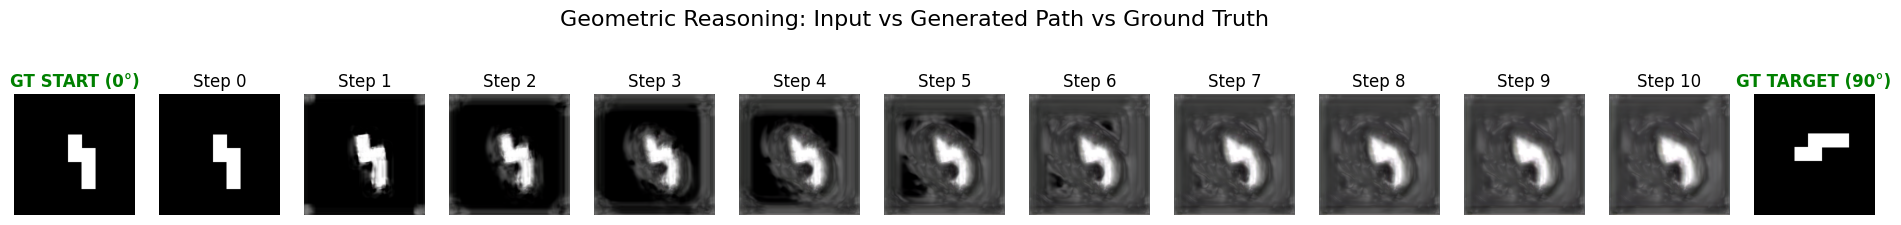

In [ ]:
import torch
import kornia.geometry.transform as K
import matplotlib.pyplot as plt
import numpy as np

def visualize_reasoning(model, x_base, steps=8):
    model.eval()
    
    # Define angles
    angle_start = torch.tensor([0.0], device=DEVICE)
    angle_end   = torch.tensor([90.0], device=DEVICE) # The Goal
    
    # Create Ground Truths
    x_start  = K.rotate(x_base, angle_start)
    x_target = K.rotate(x_base, angle_end)
    
    current_x = x_start.clone()
    
    frames = [current_x.cpu()]
    dt = 1.0 / steps
    
    with torch.no_grad():
        for i in range(steps):
            t_val = i / steps
            t = torch.tensor([[t_val]], device=DEVICE)
            
            # Predict velocity field
            v = model(current_x, t, x_start)
            
            # Integrate (Euler)
            current_x = current_x + v * dt
            frames.append(current_x.cpu())
            
    # Return frames + the ground truth start/end for comparison
    return frames, x_start.cpu(), x_target.cpu()

sample = next(iter(train_loader))[0:1].to(DEVICE).repeat(1, 3, 1, 1)

frames, gt_start, gt_target = visualize_reasoning(model, sample, steps=10)

# Setup Plot: Frames + 2 for Start/End reference
total_plots = len(frames) + 2 
fig, axes = plt.subplots(1, total_plots, figsize=(24, 3))

# Helper to denormalize
def show_img(tensor_img, ax, title, is_gt=False):
    img = tensor_img[0].permute(1, 2, 0).numpy()
    img = (img * 0.229) + 0.485 # Undo ImageNet
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    
    # Visual styling: Green title for GT, Blue for Generated
    color = 'green' if is_gt else 'black'
    font_weight = 'bold' if is_gt else 'normal'
    
    ax.set_title(title, color=color, fontweight=font_weight)
    ax.axis('off')

show_img(gt_start, axes[0], "GT START (0°)", is_gt=True)

for i, frame in enumerate(frames):
    # Skip the very first frame in the list if it's identical to GT Start, 
    # but usually nice to see the model's starting point (which is x_start)
    show_img(frame, axes[i+1], f"Step {i}")

# 3. Plot Ground Truth Target
show_img(gt_target, axes[-1], "GT TARGET (90°)", is_gt=True)

plt.suptitle("Geometric Reasoning: Input vs Generated Path vs Ground Truth", fontsize=16)
plt.show()